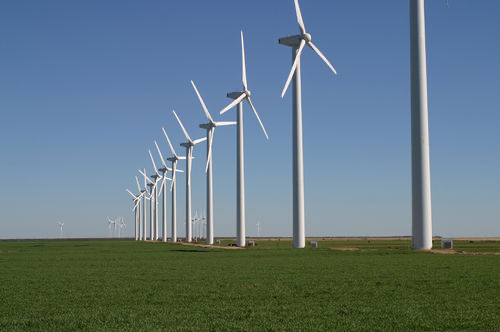!

Wind power is the generation of electricity from wind. Wind power harvests the primary energy flow of the atmosphere generated from the uneven heating of the Earth’s surface by the Sun. Therefore, wind power is an indirect way to harness solar energy. Wind power is converted to electrical energy by wind turbines.

Several different factors influence the potential wind resource in an area. The three main factors that influence power output are: wind speed, air density, and blade radius. Wind turbines need to be in areas with a lot of wind on a regular basis, which is more important than having occasional high winds.

Power output is related to the local air density, which is a function of altitude, pressure, and temperature. Dense air exerts more pressure on the rotors, which results in higher power output.

In this data set, we can find data of 'Wind Speed, 'Rain', 'Max Teemperature', 'Minimum Temperature', 'Minimum Grass Temperature' and 'Indicators'.

So if I can predict these features for the future, I can also predict how much I can generate wind power.

Reference:
https://energyeducation.ca/encyclopedia/Wind_power

In this notebook, I tried Multivariate Time Series Forecasting with LSTMs which will predict not only 'Wind speed' but also other features, 'Rain','Temperature' etc.. because the purpose is how I can predict the features to generate future 'Wind Power'

I fefered "Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras" https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

Thank you very much for sharing !

# Importing Library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import datetime

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [ ]:
df=pd.read_csv('/kaggle/input/wind-speed-prediction-dataset/wind_dataset.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['DATE']=pd.to_datetime(df['DATE'])

# Visalization

* Time Series Plot by Wind

In [ ]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

* Correlation among the features

In [ ]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

* Boxplot: 'WIND'

In [ ]:
sns.boxplot(df['WIND'])

* Boxplot:'RAIN'

In [ ]:
sns.boxplot(df['RAIN'])

* Boxplot:'Max Temperature'

In [ ]:
sns.boxplot(df['T.MAX'])

* Boxplot:'Minumum Temperature'

In [ ]:
sns.boxplot(df['T.MIN'])

* Boxplot:'Minumum Grass Temperature'

In [ ]:
sns.boxplot(df['T.MIN.G'])

* Boxplot: First indicator value

In [ ]:
sns.histplot(df['IND'])

* Boxplot: Second indicator value

In [ ]:
sns.histplot(df['IND.1'])

* Boxplot: Third indicator value

In [ ]:
sns.histplot(df['IND.2'])

In [ ]:
df = df.set_index('DATE')

* Time series of all features

In [ ]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# Features Engineering

* Replace NaN with 0

In [ ]:
df=df.fillna(0)
df.info()

* The number of instances is 6,574. I will split the dataset into train and test data in a 70% and 30% ratio of the instances.

In [ ]:
6574*0.7

* Train – Test Split

In [ ]:
train_df,test_df = df[1:4601], df[4601:] 

* Scaling the values

In [ ]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

* Converting the series to samples 

Now I will make a function that will use a sliding window approach to transform our series into samples of input past observations and output future observations to use supervised learning algorithms.

In [ ]:
def split_series(series, n_past, n_future):
  
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

For this case, let’s assume that given the past 10 days observation, we need to forecast the next 5 days observations.

In [ ]:
n_past = 10
n_future = 5 
n_features = 8

* Convert both the train and test data into samples using the split_series function.

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

# Modeling

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

In [ ]:
# E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

In [ ]:
# E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

# Training the models

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

# Inverse Scaling of the predicted values

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

# Checking Error

In [ ]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

Reference:
"Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras"
https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/